Notebook for walking through example 1 in concept chapter of thesis.

Simulates the movement of 3 individuals over 5 timesteps, makes detections using a camera moving across the survey area in one axis

**Setup starting Positions**

Sim variables:

1. survey area
2. Number of individuals

In [2]:

survey_x = 5
survey_y = 1

n_inds = 3

Randomise starting points of the individuals

In [3]:
import numpy as np
from src.simulate import initial_positions

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib notebook


Plot starting scenario

<IPython.core.display.Javascript object>


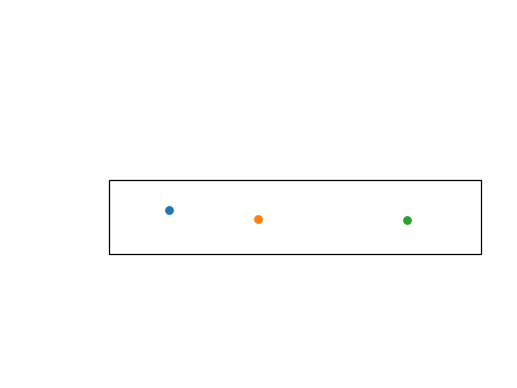

In [6]:
area = [0, survey_x, 0, survey_y]

starting_x, starting_y = initial_positions(n_inds, area)
starting_x = [.8, 2., 4.] 

fig, ax = plt.subplots()

for x,y in zip(starting_x, starting_y):
    ax.scatter(x, y)

ax.axis('equal')
ax.set_xlim(0-.5, survey_x + .5)
ax.set_ylim(0-.5, survey_y + .5)

ax.axis('off')

ax.add_patch(Rectangle((0,0), survey_x, survey_y, fill=False))

plt.show()


**Simulate vehicle track**

Vehicle parameters:
1. camera area
2. vehicle step size

Animal parameter:
1. Variance

In [7]:
cam_area = [1, 1]
c_step = 0.6

var = 0.1

Camera moves along X axis by c_step every timestep

In [8]:
cam_starting_x = 0

c_x = 0

cam_x = [c_x]
while c_x+cam_area[0] < survey_x:
    c_x += c_step
    cam_x.append(c_x)

cam_y = [0]*len(cam_x)

<IPython.core.display.Javascript object>


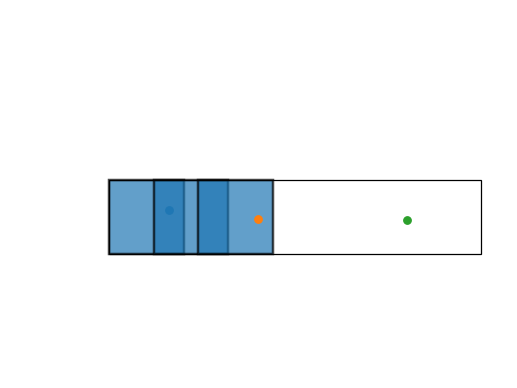

In [9]:
fig, ax = plt.subplots()


for x, y in zip(cam_x[:3], cam_y[:3]):
    ax.add_patch(Rectangle((x,y), cam_area[0], cam_area[1], edgecolor='black', linewidth=2, alpha=0.7, zorder=0))
    
for x,y in zip(starting_x, starting_y):
    ax.scatter(x, y)
    
ax.axis('square')
ax.set_xlim(0-.5, survey_x + .5)
ax.set_ylim(0-.5, survey_y + .5)


ax.axis('off')

ax.add_patch(Rectangle((0,0), survey_x, survey_y, fill=False))


plt.show()


**Simulate animal movement and detections**

In [10]:
n_steps = len(cam_x)

In [11]:
def simulate2(starting, norm):
    return [s + np.random.normal(0, norm, 2) for s in starting]

def simulate1(starting, norm):
    return [s + np.random.normal(0, norm) for s in starting]

def simulate(starting, norm, n_steps, d2=False):
    s = [starting]
    for i in range(n_steps):
        if d2:
            s.append(simulate2(s[i], norm))
        else:
            s.append(simulate1(s[i], norm))
    
    return np.array(s)

<IPython.core.display.Javascript object>


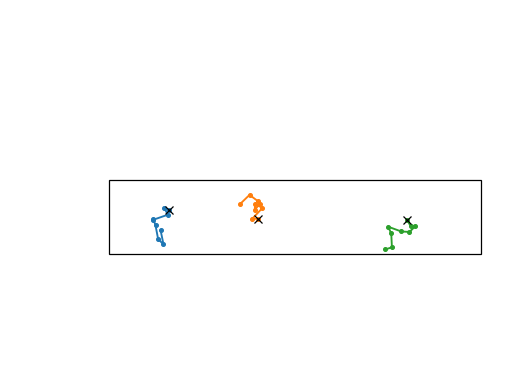

In [12]:
starting = np.array([[x,y] for x,y in zip(starting_x, starting_y)])

positions = simulate(starting, var, n_steps, d2=True)
    

fig, ax = plt.subplots()

for i in range(n_inds):
    ax.plot(positions[:, i, 0], positions[:, i, 1], '-o', markersize=3)

ax.plot(starting_x, starting_y, 'kx')
ax.axis('square')
ax.set_xlim(0-.5, survey_x + .5)
ax.set_ylim(0-.5, survey_y + .5)


ax.axis('off')

ax.add_patch(Rectangle((0,0), survey_x, survey_y, fill=False))

fig.show()

Now that we have the animal tracks and camera path, go through step by step to get the detections (i.e. when an animal is in frame of the camera)

In [13]:
def in_cam(cam_x, cam_y, t, footprint, positions):
    cx = cam_x[t]
    cy = cam_y[t]
 
    pos = positions[t]

    dets = []

    for p in pos:

        inx = np.logical_and(cx  <= p[0], p[0] <= cx + cam_area[0])
        iny = np.logical_and(cy  <= p[1], p[1] <= cy + cam_area[1])
        dets.append([np.logical_and(inx, iny)])
    return dets
    
    

In [14]:
detections = []

for t in range(n_steps):
    d = in_cam(cam_x, cam_y, t, cam_area, positions)
    # each detection is [timestep, individual]
    npw = np.where(d)
    if len(npw[0]) >0:
        for ind in npw[0]:
            detections.append([t, ind])
    

In [15]:
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]

<IPython.core.display.Javascript object>


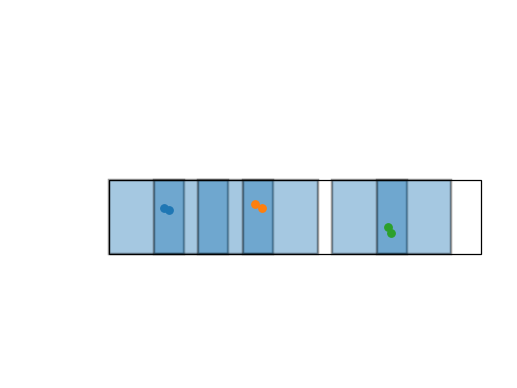

In [16]:
fig, ax = plt.subplots()

for d in detections:
    t = d[0]
    ind = d[1]
    
    pos = positions[t][ind]
    ax.scatter(pos[0], pos[1], color=clrs[ind])
    ax.add_patch(Rectangle((cam_x[t], cam_y[t]), cam_area[0], cam_area[1], edgecolor='black', linewidth=2, alpha=0.4, zorder=0))
    
ax.axis('square')
ax.set_xlim(0-.5, survey_x + .5)
ax.set_ylim(0-.5, survey_y + .5)


ax.axis('off')

ax.add_patch(Rectangle((0,0), survey_x, survey_y, fill=False))

plt.show()
    

**Build and score hypotheses**

In [17]:
det_arr = np.array(detections)
det_arr

array([[0, 0],
       [1, 0],
       [2, 1],
       [3, 1],
       [5, 2],
       [6, 2]])

get detection info together iin a dataframe

In [18]:
import pandas as pd

In [19]:
df = pd.DataFrame(columns=['time', 'individual', 'x', 'y'])
df["time"] = det_arr[:, 0]
df["individual"] = det_arr[:, 1]

df["x"] = df.apply(lambda row: positions[row["time"], row["individual"], 0], axis=1)
df["y"] = df.apply(lambda row: positions[row["time"], row["individual"], 1], axis=1)

In [21]:
df

,time,individual,x,y
0,0,0,0.800000,0.593287
1,1,0,0.737795,0.627586
2,2,1,2.058370,0.621813
3,3,1,1.962302,0.681668
4,5,2,3.748339,0.372029
5,6,2,3.790978,0.281589


In [22]:
from scipy.spatial.distance import mahalanobis

In [23]:
cov = np.array([[var, 0], [0, var]])


def get_last(hyp):
    h = hyp[:-1]
    tlast = (~np.isnan(h)).cumsum().argmax()
    return hyp[tlast]

# decide whether a track should be discarded or not (based on mahalanobis dist)
# should only run this if neither the current and previous detection aren't nans
def gating(track, df, var, thresh):
    
    # get the id of the current and previous detection in the track
    this = track[-1]
#     print(this)
    last = get_last(track)
    
    if np.logical_or(np.isnan(this), np.isnan(last)):
        return "keep"
    else:
        # get the xy position of the current and previous detection    
        thispos = df.loc[this][["x", "y"]].to_numpy()
        lastpos = df.loc[last][["x", "y"]].to_numpy()

        # get the time of the detections
        thist = df.loc[this].time
        lastt = df.loc[last].time

        # calculate the elapsed time between the detections    
        dt = thist - lastt

        # build the covariance matrix and calculate the malahanobis distance between detections
        cov = np.array([[dt*var, 0], [0, dt*var]])
        d2 = mahalanobis(lastpos, thispos, cov)
#         print("mahal = ", d2)
        # if 
        if d2 > thresh:
            return "discard"
        else:
            return "keep"


def update_tracks(det, hyps):
    new_hyps=[]
    for i, hyp in enumerate(hyps):
        missed_scen = hyp + [np.nan]
        
        
        new_hyps.append( missed_scen )
        
        for detection_id in det.index:
            repeat_scen = hyp + [detection_id]
            new_hyps.append(repeat_scen)
    return new_hyps

In [24]:
t = 0
det = df[df.time == t]

tracks = [[i] for i,row in det.iterrows()]
tracks.append([np.nan])

In [27]:
for t in tracks:
    print(t)

[0]
[nan]


In [28]:
t = 1
det = df[df.time == t]
tracks = update_tracks(det, tracks)
for t in tracks:
    print(t)

[0, nan]
[0, 1]
[nan, nan]
[nan, 1]


In [32]:
df

,time,individual,x,y
0,0,0,0.800000,0.593287
1,1,0,0.737795,0.627586
2,2,1,2.058370,0.621813
3,3,1,1.962302,0.681668
4,5,2,3.748339,0.372029
5,6,2,3.790978,0.281589


In [31]:

for t in tracks:
    print("track: ", t, 
          "gate? ", gating(t, df, var, thresh=1))

track:  [0, nan] gate?  keep
track:  [0, 1] gate?  keep
track:  [nan, nan] gate?  keep
track:  [nan, 1] gate?  keep


In [33]:
t = 2
det = df[df.time == t]
tracks = update_tracks(det, tracks)
for t in tracks:
    print(t)

[0, nan, nan]
[0, nan, 2]
[0, 1, nan]
[0, 1, 2]
[nan, nan, nan]
[nan, nan, 2]
[nan, 1, nan]
[nan, 1, 2]


In [37]:
for t in tracks:
    print("track: ", t, 
          "gate? ", gating(t, df, var, thresh=.5))

track:  [0, nan, nan] gate?  keep
track:  [0, nan, 2] gate?  discard
track:  [0, 1, nan] gate?  keep
track:  [0, 1, 2] gate?  keep
track:  [nan, nan, nan] gate?  keep
track:  [nan, nan, 2] gate?  keep
track:  [nan, 1, nan] gate?  keep
track:  [nan, 1, 2] gate?  keep


In [93]:
for t in df.time.unique()[3:]:
    det = df[df.time == t]
    
    tracks = update_tracks(det, tracks)

In [94]:
for t in tracks

[[0, nan, nan, nan, nan, nan],
 [0, nan, nan, nan, nan, 5],
 [0, nan, nan, nan, 4, nan],
 [0, nan, nan, nan, 4, 5],
 [0, nan, nan, 3, nan, nan],
 [0, nan, nan, 3, nan, 5],
 [0, nan, nan, 3, 4, nan],
 [0, nan, nan, 3, 4, 5],
 [0, nan, 2, nan, nan, nan],
 [0, nan, 2, nan, nan, 5],
 [0, nan, 2, nan, 4, nan],
 [0, nan, 2, nan, 4, 5],
 [0, nan, 2, 3, nan, nan],
 [0, nan, 2, 3, nan, 5],
 [0, nan, 2, 3, 4, nan],
 [0, nan, 2, 3, 4, 5],
 [0, 1, nan, nan, nan, nan],
 [0, 1, nan, nan, nan, 5],
 [0, 1, nan, nan, 4, nan],
 [0, 1, nan, nan, 4, 5],
 [0, 1, nan, 3, nan, nan],
 [0, 1, nan, 3, nan, 5],
 [0, 1, nan, 3, 4, nan],
 [0, 1, nan, 3, 4, 5],
 [0, 1, 2, nan, nan, nan],
 [0, 1, 2, nan, nan, 5],
 [0, 1, 2, nan, 4, nan],
 [0, 1, 2, nan, 4, 5],
 [0, 1, 2, 3, nan, nan],
 [0, 1, 2, 3, nan, 5],
 [0, 1, 2, 3, 4, nan],
 [0, 1, 2, 3, 4, 5],
 [nan, nan, nan, nan, nan, nan],
 [nan, nan, nan, nan, nan, 5],
 [nan, nan, nan, nan, 4, nan],
 [nan, nan, nan, nan, 4, 5],
 [nan, nan, nan, 3, nan, nan],
 [nan, nan, n

In [49]:
df

,time,individual,x,y
0,0,0,0.800000,0.311160
1,1,0,0.809414,0.396511
2,2,1,2.014838,0.293865
3,3,1,2.126503,0.237409
4,5,2,3.777105,0.299853
5,6,2,3.870928,0.311347


In [50]:
tr = np.array(tracks)

In [51]:
tr[:, :3]

array([[ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan, nan],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0., nan,  2.],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1., nan],
       [ 0.,  1.,  2.],
       [ 0.,  1.,  2.],
       [ 0.,  1.,  2.],
       [ 0.,  1.,  2.],
       [ 0.,  1.,  2.],
       [ 0.,  1.,  2.],
       [ 0.,  1.,  2.],
       [ 0.,  1.,  2.],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan,  2.],
       [nan, nan

**Analyse predicted distributions**